# Bias of Gradient in Stochastic Gradient Descent (SGD)

We are interested in if the gradient of a mini-batch in SGD is biased, compared to the full gradient of the dataset. Specifically, $\forall \theta \in \Theta$, does

\begin{equation}
\frac{1}{m} E( \nabla L(X_m, Y_m, \theta) ) = \frac{1}{n} \nabla L(X_n, Y_n, \Theta)?
\end{equation}

We try to answer this computationally since it may be hard to to analytically. To do this at a given $\theta$, we calculate the "true" gradient of the full dataset and generate many mini-batch gradients at the same $\theta$ as well. From these mini-batch gradients, we can compute distributions of the differences from the true value for each entry of theta. We could also plot things like 

In [1]:
import gpytorch
import torch
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt

import pdb

random.seed(123)
np.random.seed(123)

# Helpers

In [2]:
def relative_distance(x, y):
    """ Computes 'relative' distance between two PyTorch Tensors. If x is the base tensor, this is |x - y| / |x|. """
    return torch.norm(x - y).item() / torch.norm(x).item()

# Data

We adapt the data from "one dimension, three parameters" from Li. The kernel is $k(x, x') = o^2 \exp \Big( \frac{-|x-x'|^2}{2 \cdot l^2} \Big)$ where $o = 4$ and $l = 2$. We also add noise $\sigma = 0.1$ to the covariance matrix.

In [3]:
# Simulation specifications
n = 200
sigma_sq = 0.1**2
outputscale = 4**2
lengthscale = 2

# Features
X = torch.linspace(0, 100, n)
# Targets
data_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
data_kernel.outputscale = outputscale
data_kernel.base_kernel.lengthscale = lengthscale
Sigma = (data_kernel(X, X) + torch.diag(torch.Tensor([sigma_sq for _ in X]))).detach().numpy()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Y = torch.Tensor(np.random.multivariate_normal(np.zeros(n), Sigma, size = 1).ravel())

# Model

In [4]:
# Simple Model From GPyTorch Regression Tutorial
class ExactGPModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def initialize(self, noise = None, outputscale = None, lengthscale = None):
        if noise is not None:
            self.likelihood.noise_covar.noise = noise**2
        if outputscale is not None:
            self.covar_module.outputscale = outputscale**2
        if lengthscale is not None:
            self.covar_module.base_kernel.lengthscale = lengthscale

# Distributions of $\nabla L_m$ for a few $\theta$

In [5]:
# 'True' parameter values
sigma_true = 0.1
outputscale_true = 4
lengthscale_true = 2

In [6]:
def check_theta(noise = None, outputscale = None, lengthscale = None, m = 10, nbins = 50):
    """ Plots distibutions of minibatch gradients, relative to true gradient, for a given theta.
    The theta is supplied through a given initialization function that sets the model's
    parameters to theta. """
    
    print(f'Using m = {m}')
    
    # Model Setup
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(X, Y, likelihood)
    # Loss
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    # For zero-ing gradients
    optimizer = torch.optim.Optimizer(model.parameters(), {})

    # Setting to eval mode since we will never be training
    _ = model.eval()
    _ = likelihood.eval()
    
    # Initializing
    model.initialize(noise, outputscale, lengthscale)   
    
    # Getting the true gradient
    with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cholesky_size(n + 1):
        optimizer.zero_grad()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            preds = model(X)
        loss = -mll(preds, Y)
        loss.backward()
    nL = torch.cat([torch.flatten(param.grad) for _, param in model.named_parameters()])
    print(f'True Gradient = {nL}')
    
    # Getting a minibatch gradients
    nLms = []
    for _ in range(1000):
        minibatch = np.random.choice(X.shape[0], m, replace = False)
        with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cholesky_size(n + 1):
            optimizer.zero_grad()
            output = model(X[minibatch])
            loss = -mll(output, Y[minibatch])
            loss.backward()
        nLm = torch.cat([torch.flatten(param.grad) for _, param in model.named_parameters()])
        nLms.append(nLm)
    
    # Plotting distributions for each parameter
    fig, ax = plt.subplots(2, 2, figsize = (24, 10))
    nLms_sep = {param_pair[0]: [nLm[i].item() for nLm in nLms] for i, param_pair in enumerate(model.named_parameters())}
    for i, param_pair in enumerate(model.named_parameters()):
        param_name, ax_i = param_pair[0], ax.flatten()[i]
        ax_i.hist(nLms_sep[param_name], bins = nbins)
        ax_i.axvline(nL[i].item(), color = 'black', linestyle = 'dashed')
        ax_i.set_title(param_name)
    plt.show()
    
    # Plotting relative distance and cosine similarity distributions
    fig, ax = plt.subplots(1, 2, figsize = (24, 5))
    # Relative distance
    ax[0].hist([relative_distance(nL, nLm) for nLm in nLms], color = 'firebrick', bins = nbins)
    ax[0].axvline(1, color = 'black', linestyle = 'dashed')
    ax[0].set_title('Relative Distance')
    # Cosine similarity
    cos = torch.nn.CosineSimilarity(dim = -1)
    ax[1].hist([cos(nL, nLm) for nLm in nLms], color = 'seagreen', bins = nbins)
    ax[1].axvline(1, color = 'black', linestyle = 'dashed')
    ax[1].set_title('Cosine Similarity')
    plt.show()

Using m = 10
True Gradient = tensor([ 0.2939, -0.0117, -6.2490, -0.6524])


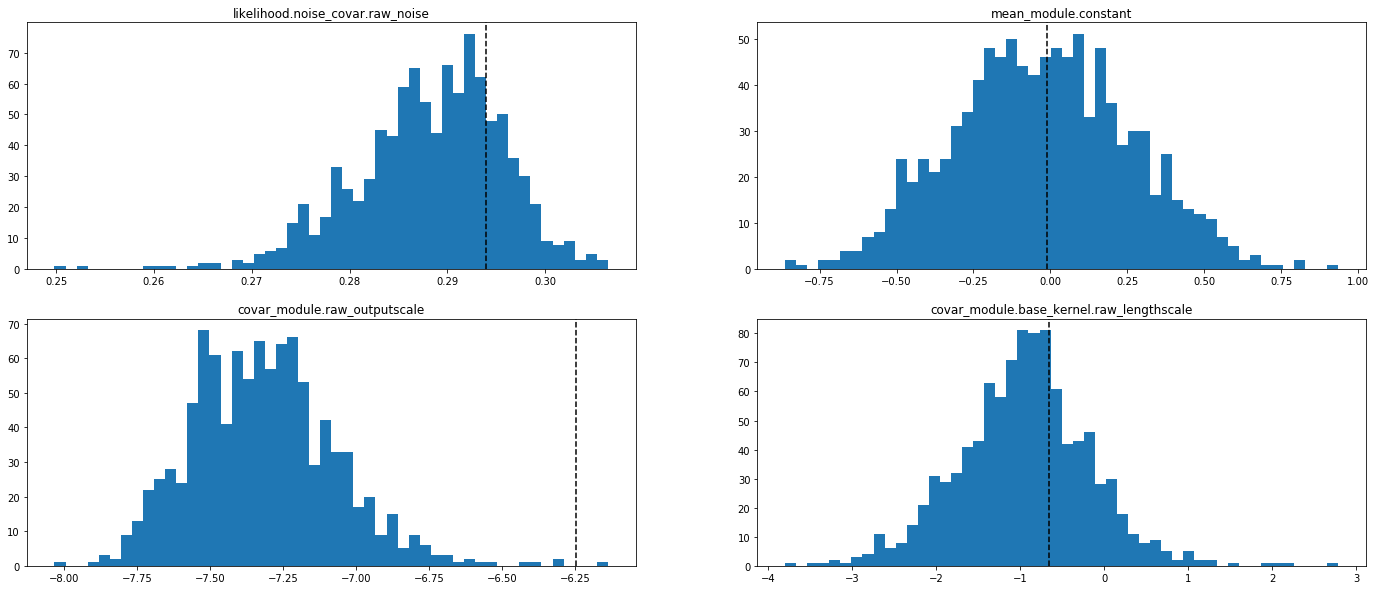

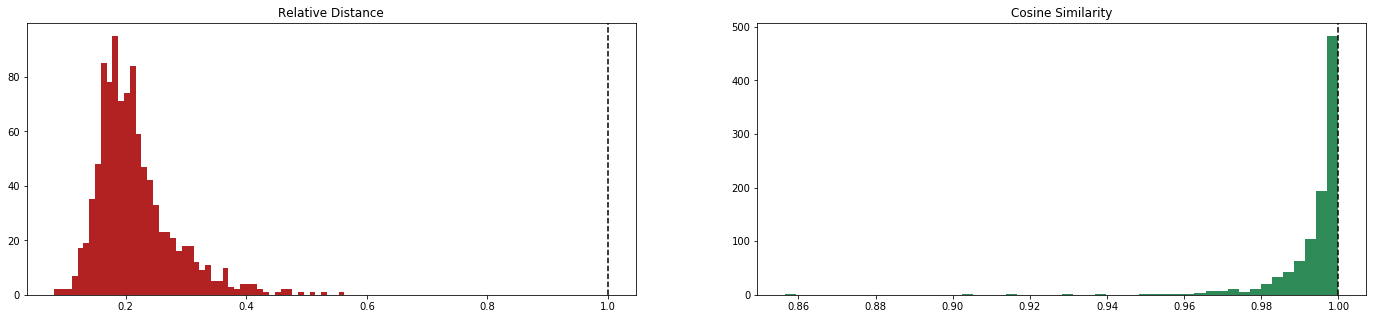

In [7]:
# Mixed of above and below true values
check_theta(noise = 0.2, outputscale = 3, lengthscale = 1)

Using m = 10
True Gradient = tensor([-3.2879e-01, -5.9947e-03, -1.1138e+01,  6.3872e+00])


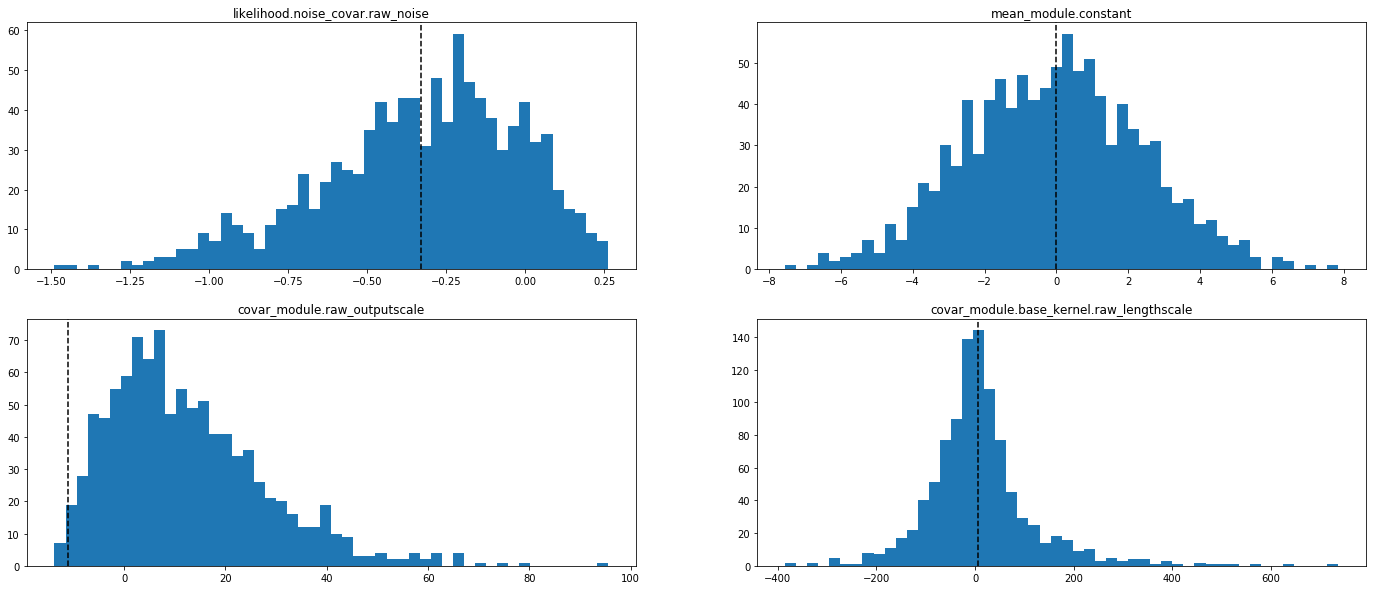

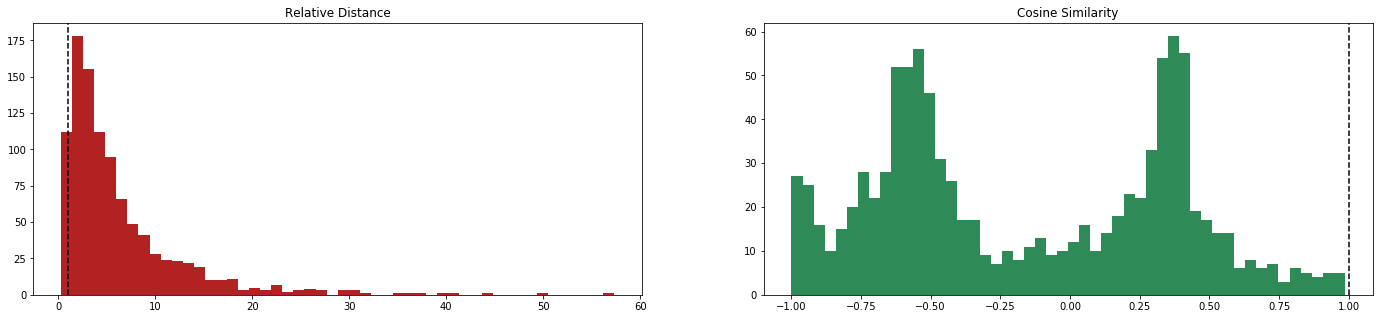

In [8]:
# Above true values
k = 1.5
check_theta(k*sigma_true, k*outputscale_true, k*lengthscale_true)

Using m = 10
True Gradient = tensor([-1.6809e-01, -3.0345e-02, -9.8264e+01,  3.8181e-01])


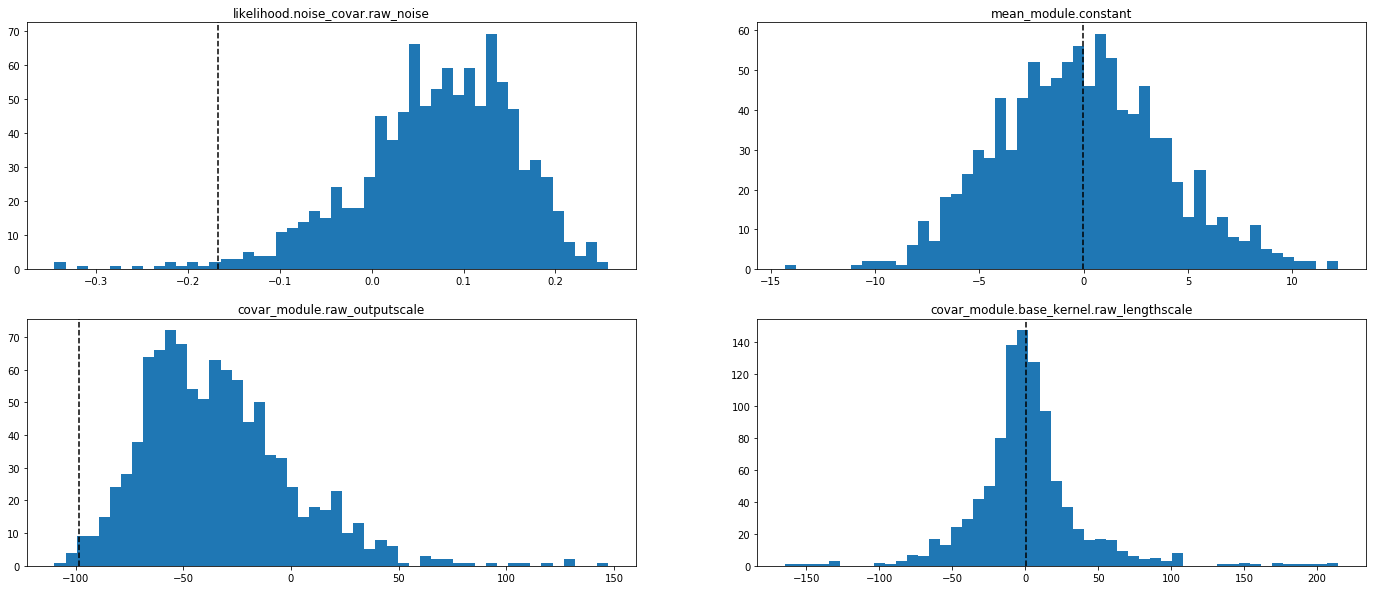

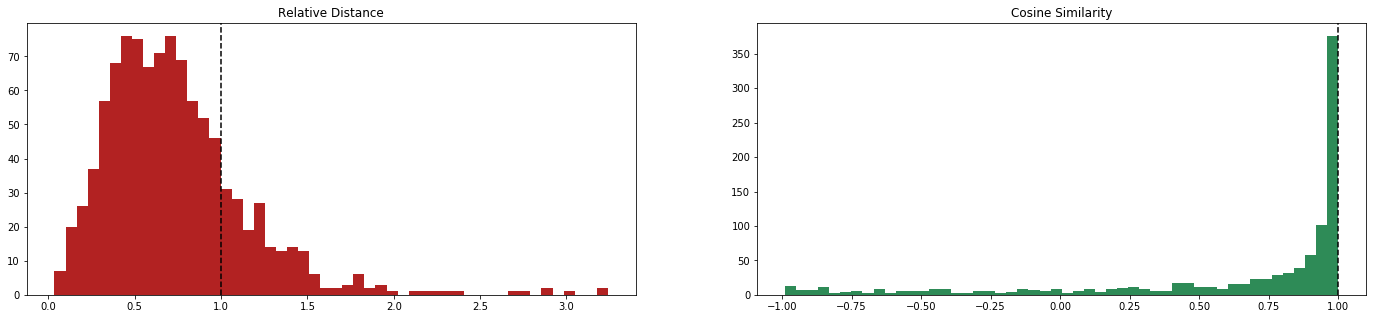

In [9]:
# Below true values
k = 0.5
check_theta(k*sigma_true, k*outputscale_true, k*lengthscale_true)

Discussion

- Both the subsampled and full gradients are scaled by the sample size
- The gradient does appear to be biased. The means of these distributions don't always appear by the vertical dotted line where they should be.
- Cosine similarity is good for first and third plots, but second one is wild.

# Plotting Bias vs Parameters Values

Here, we separately vary each parameter. For each value, we 